In the [previous post](../painting-classifier/index.ipynb), we saw how to train a model (to classify Picasso and Monet paintings) and save the trained model in `fastai`. In this post, let us create an app using `gradio` that uses the trained model and we will also learn how to deploy the app using **Hugging Face Spaces** so that others can use our app. Incase if you are not familiar with training and saving a model, I suggest you to go through [Picasso and Monet Painting Classifier](../painting-classifier/index.ipynb) post.

# Install Libraries

Let's start by installing necessary Python packages.

```bash
pip install -Uqq fastai # <1>
pip install -Uqq gradio # <2>
```

1. Installs `fastai`. It provides functions to load the model trained using `fastai`.
2. Installs `gradio`. It is a library used to build web interfaces using Python.

# Predict using trained model

Let us now load the trained model and make predictions on sample images.

## Import packages

To load the model, we need to import necessary modules from `fastai`. `fastai.vision.all` module provides functions related to computer vision tasks.

In [3]:
from fastai.vision.all import *

## Load the model

In [ ]:
learn = load_learner('model.pkl') # <1>

1. Loads the trained model saved as `model.pkl` file.

```python
NotImplementedError: cannot instantiate 'PosixPath' on your system
```

Unfortunately when you load the model in a `Windows` system, it throws above error. Because in my case, I trained and saved the model in a `Linux` system and trying to load it in `Windows`. To get rid of this error, below code should be run before loading the model.

In [ ]:
import platform
if platform.system() == 'Windows': # <1>
    import pathlib
    pathlib.PosixPath = pathlib.WindowsPath

1. Checks if the OS where the code is run is `Windows`?

In [6]:
learn = load_learner('model.pkl')

Now the model is loaded successfully 🙂! Before making the predictions, let's see the possible predictions (labels) of the model.

In [12]:
labels = learn.dls.vocab # <1>
labels

['monet painting', 'picasso painting']

1. `dls` refers to `DataLoaders` and `vocab` refers to the class labels.

Given an image as input our model will predict either ***monet painting*** or ***picasso painting***.

## Predict

Let's read an image and make prediction with the loaded model.

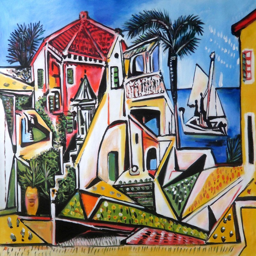

In [8]:
img = PILImage.create('images/picas3.jpg') # <1>
img.to_thumb(256) # <2>

1. Read the image from the path `images/picas3.jpg`.
2. Resize the image to a thumbnail of size 256.

Now pass the loaded image to the model's `predict` method which returns the class label.

In [9]:
pred_label, pred_index, class_probs = learn.predict(img)
print("Prediction:", pred_label)
print("Class probabilities:", class_probs)
print("Prediction Index:", pred_index)

Prediction: picasso painting
Class probabilities: tensor([0.0028, 0.9972])
Prediction Index: tensor(1)


We could see the model predicting it's a ***Picasso's painting and it is 99% confident*** about it. We can use the prediction index in the class probabilities array to get the probability (confidence) score of the predicted label.

Let's wrap the above logic to a function which gets image path as input and returns a dictionary with class label and confidence score as output.

In [16]:
def predict(img_path):
    img = PILImage.create(img_path) # <1>
    pred_label, pred_index, class_probs = learn.predict(img) # <2>
    output = {labels[i]:float(class_probs[i]) for i in range(len(labels))} # <3>
    return output

1. Read image in the `img_path`.
2. Make predictions for the image.
3. Create output dictionary where key is the class label and value is the probability score. The output is specifically constructed like this because `gradio` expects the labels to be in this format. We'll discuss about `gradio` in the next section.

Now let's use the `predict` function to make predictions for few images.

In [17]:
predict('images/picas1.jpg')

{'monet painting': 1.7153462977148592e-05,
 'picasso painting': 0.9999828338623047}

In [18]:
predict('images/mon2.jpg')

{'monet painting': 0.999991774559021,
 'picasso painting': 8.193430403480306e-06}

Now we successfully loaded the trained model and made predictions, let's develop an app and use this model in it.

# Create Web Interface using Gradio

We can create an application using any web (or app) frameworks and use our model in it. Since we are already familiar with Python, we can use Python libraries to create User Interfaces quickly with no app development background. There are few popular packages to do it like **Streamlit** and **Gradio**. In this post, we will see how to develop an app using Gradio with very few lines of code.

Let's start by importing `gradio`.

In [35]:
import gradio as gr

Gradio provides a high-level abstraction (`gr.Interface`) that allows us to quickly create a demo for any Python function (we have `predict` function!) simply by specificying the input types and output types.

In [36]:
demo = gr.Interface(
    inputs=gr.Image(height=400),
    outputs=gr.Label(),
    fn=predict,
)

We see that the Interface class is initialized with three required parameters:

1. `fn`: the function to wrap a user interface (UI) around
2. `inputs`: which Gradio component(s) to use for the input. The number of components should match the number of arguments in your function.
3. `outputs`: which Gradio component(s) to use for the output. The number of components should match the number of return values from your function.

To run the app, call `launch` method. It runs the app and by default serves at `http://127.0.0.1:7860`. Open this URL in your browser to see the app.

In [ ]:
demo.launch()

<figure>
    <img src="app0.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 360px">
    <figcaption></figcaption>
</figure>

In Jupyter notebook, we can close the running app using `close` method.

In [38]:
demo.close()

Closing server running on port: 7860


Let's add title and description to our app by setting the `title` and `description` parameters.

In [43]:
title = "Painting Classifier"
description = "A painting classifier trained to classify Picasso and Monet paintings using dataset scrapped from Duck Duck Go Image search."

demo = gr.Interface(
    inputs=gr.Image(height=400),
    outputs=gr.Label(),
    fn=predict,
    title=title,
    description=description,
)

In [ ]:
demo.launch()

<figure>
    <img src="app1.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 360px">
    <figcaption></figcaption>
</figure>

Our app is almost ready. Now user can drop an image in the input widget or click to upload an image. Once the image is uploaded, clicking the 'Submit' button will call the `predict` function and returns the output and is displayed. Let's see it in action.

<figure>
    <img src="app2.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 360px">
    <figcaption></figcaption>
</figure>

In [45]:
demo.close()

Closing server running on port: 7860


The app is ready now. It may be bit confusing for new users what kind of input they should be using. Wouldn't it be good if we add few examples inputs to the app? Luckily, gradio supports it out of the box with just a parameter. Let's add examples to the app using `examples` parameter which takes a list of image paths.

In [48]:
demo = gr.Interface(
    inputs=gr.Image(height=400),
    outputs=gr.Label(),
    fn=predict,
    title=title,
    description=description,
    examples=['images/picas3.jpg', 'images/picas1.jpg'],
)

In [ ]:
demo.launch()

<figure>
    <img src="app3.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 480px">
    <figcaption></figcaption>
</figure>

You can see a new section **Examples** below the Clear and Submit buttons. User can click this to use as inputs.

In [50]:
demo.close()

Closing server running on port: 7860


# Deploy the app

We have created the app and accessed it locally in the browser. Wouldn't it be good if we deploy it and share with others to use? Without any server setup, Hugging Face Spaces help us to achieve it through simple steps for free!

Before following further, create a [Hugging Face account](https://huggingface.co/join)

<figure>
    <img src="hf1.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 360px">
    <figcaption></figcaption>
</figure>

## Hugging Face Spaces

Let's create a space for our gradio app. Once you log into your Hugging Face account, go to [Hugging Face Spaces](https://huggingface.co/spaces) and click `Create new space`.

<figure>
    <img src="hf2.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 480px">
    <figcaption></figcaption>
</figure>

You will be landed to a form where we will be giving basic details like the space name, license, app framework, what kind of server configs we need etc., Hugging Face provides variety of hardware like CPUs and GPUs. For our demo, we will choose the free CPU.

<figure>
    <img src="hf3.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 480px; width: 70%">
    <figcaption></figcaption>
</figure>

<figure>
    <img src="hf4.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 420px; width: 70%;">
    <figcaption></figcaption>
</figure>

Once you click `Create Space`, Hugging Face will create a git repo for you which we need to clone locally and update them with trained model and python scripts. Then the updated local repo should be pushed to Hugging Face remote repo.

Let's clone the repo as per the instruction given.
```bash
git clone https://huggingface.co/spaces/harishb00/painting-classifier
```

## Convert Jupyter code to python script

Convert all the code we written in Jupyter notebook to Python script and save it to `app.py` file in the cloned repo. Once we do it, it looks like below

```{.python .code-overflow-wrap filename="app.py"}
import platform
from fastai.vision.all import *
import gradio as gr


if platform.system() == 'Windows':
    import pathlib
    pathlib.PosixPath = pathlib.WindowsPath

learn = load_learner('model.pkl')
labels = learn.dls.vocab

def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Painting Classifier"
description = "A painting classifier trained to classify Picasso and Monet paintings using dataset scrapped from Duck Duck Go Image search."
demo = gr.Interface(
    inputs=gr.Image(height=400),
    outputs=gr.Label(),
    fn=predict,
    title=title,
    description=description,
    examples=['images/picas3.jpg', 'images/picas1.jpg'],
)
demo.launch()
```

Also create a requirements file inside cloned repo with Python packages required to run the script.

```{.text filename="requirements.txt"}
fastai
gradio
```

Copy the model file and image example files to the same folder. Once you are done with all the steps, your folder structure looks like this.

<figure>
    <img src="fold0.png"
        alt="thumbnail"
        class="post-thumbnail"
        style="height: 360px;">
    <figcaption></figcaption>
</figure>

## Commit and Push

It's time to commit and push the code to Hugging Face Spaces. Execute below commands in your terminal.

```bash
git add .
git commit -m "app commit"
git push
```

::: {.callout-tip}
## `git push` hangs

git push hangs at 74% for me since the uploaded model file is a large one. `git config --global http.postBuffer 157286400` fixed the issue by increasing the git buffer.
:::

That's it. In few minutes, your app is live and you can visit the Hugging Face Spaces project URL (URL used with `git clone URL`) to use/share your app.

# References

* [Fastai Course - Lesson 2](https://course.fast.ai/Lessons/lesson2.html)
* [Tanishq Abraham's HF Spaces Tutorial](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html)
* [Gradio Documentation](https://www.gradio.app/)